In [1]:
from sklearn.ensemble import RandomForestClassifier
from Preprocess import Preprocessor, new_OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, RFECV, SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgbm
from sklearn.preprocessing import KBinsDiscretizer
plt.rcParams.update({'text.color' : "w",
                     'axes.labelcolor' : "w",
                     'xtick.color' : "w",
                     'ytick.color' : "w"})

In [2]:
data = pd.read_csv('titanic.csv')
train,test = train_test_split(data,test_size=0.2,random_state=42)
X_train,y_train,X_test,y_test = train.drop('Survived',axis=1),train['Survived'],test.drop('Survived',axis=1),test['Survived']

In [3]:
train.reset_index(drop=True,inplace=True)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,"Cleaver, Miss. Alice",female,22.0,0,0,113781,151.5500,NaN,S
1,0,2,"Hunt, Mr. George Henry",male,33.0,0,0,SCO/W 1585,12.2750,NaN,S
2,1,3,"Nakid, Miss. Maria (""Mary"")",female,1.0,0,2,2653,15.7417,NaN,C
3,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.5500,NaN,S
4,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,S


In [4]:
X_train.dtypes

Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

([<matplotlib.axis.XTick at 0x15775a70be0>,
 <a list of 3 Text major ticklabel objects>)

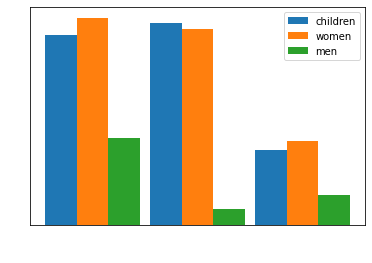

In [5]:
classes = pd.DataFrame(np.zeros((3,4)),columns=['Class','Child Survival Rate','Woman Survival Rate', 'Male Survival Rate'])
for c in range(1,4):
    kids = train[(train['Pclass']==c) & (train['Age']<18)]['Survived']
    women = train[(train['Pclass']==c) & (train['Age']>18) & (train['Sex'] == 'female')]['Survived']
    men = train[(train['Pclass']==c) & (train['Age']>18) & (train['Sex'] == 'male')]['Survived']
    classes.iloc[c-1,:] = [c,kids.mean(),women.mean(),men.mean()]
w = 0.3
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.bar(classes.iloc[:,0]-w,classes.iloc[:,1],width=w)
ax.bar(classes.iloc[:,0],classes.iloc[:,2],width=w)
ax.bar(classes.iloc[:,0]+w,classes.iloc[:,3],width=w)
plt.xlabel('pclass')
legend = plt.legend(['children','women','men'])
plt.setp(legend.get_texts(), color='k')
plt.xticks([1,2,3])
# print(w_classes)


In [6]:
data['Name']


0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
885                 Rice, Mrs. William (Margaret Norton)
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
Name: Name, Length: 890, dtype: object

In [7]:
print('cabin nan survival rate',train[train['Cabin'].isna()].sort_values(by='Pclass')['Survived'].mean())
print('age nan survival rate',train[train['Age'].isna()].sort_values(by='Pclass')['Survived'].mean())
print('cabin nan with age surv. rate',train[train['Cabin'].isna() & ~train['Age'].isna()].sort_values(by='Pclass')['Survived'].mean())
nan_classes = train[train['Cabin'].isna()].groupby('Pclass')
print(nan_classes['Survived'].mean())
classes = train.groupby('Pclass')
print(classes['Survived'].mean())

cabin nan survival rate 0.2909090909090909
age nan survival rate 0.2898550724637681
cabin nan with age surv. rate 0.2997658079625293
Pclass
1    0.413793
2    0.432836
3    0.232558
Name: Survived, dtype: float64
Pclass
1    0.635294
2    0.462069
3    0.236776
Name: Survived, dtype: float64


i.e. cabin & age nan-ness is independant for the most part.
also, looks like NaN cabin affects Pclass 1 much more than class 2&3.

In [8]:
train['Survived'].mean()

0.37780898876404495

In [9]:
# inhereted some other private class, doesn't even need it, so I deleted it.
class new_OrdinalEncoder():
    def __init__(self,cat_index='all'):
        self.dicts={}
        # cat_index is the categorical feature index list
        self.cat_index=cat_index

    def fit(self,df,*y):
        if self.cat_index=='all':
            self.cat_index=list(range(df.shape[1]))
        for feat in self.cat_index:
            dic=np.unique(df.iloc[:,feat])
            dic=dict([(i,index) for index, i in enumerate(dic)])
            self.dicts[feat]=dic

    def fit_transform(self,df,*y):
        if self.cat_index=='all':
            self.cat_index=list(range(df.shape[1]))
        df_output=df.copy()
        for feat in self.cat_index:
            dic=np.unique(df.iloc[:,feat])
            dic=dict([(i,index) for index, i in enumerate(dic)])
            self.dicts[feat]=dic
            df_output.iloc[:,feat]=df.iloc[:,feat].apply(lambda x: dic[x])
        return df_output

    def transform(self,df):
        df_output=df.copy()
        for feat in self.cat_index:
            dic=self.dicts[feat]
            df_output.iloc[:,feat]=df.iloc[:,feat].apply(self.unknown_value,args=(dic,))
        return df_output

    def get_dict(self,feat):
        return self.dicts[feat]

    def unknown_value(self,value,dic): # It will set up a new interger for unknown values!
        try:
            return dic[value]
        except:
            return len(dic)

# Feature creation

1,2 in OneNote - NaNs (Age & Cabin).

In [10]:
def get_isna(cols):
    res = cols.isna().astype(int)
    res.rename((lambda x: x+'_is_na'),axis=1,inplace=True)
    # print(pd.concat([cols,res],axis=1).head())
    return res
train = pd.concat([train,get_isna(train[['Age','Cabin']])],axis=1)


7, 8, 9 in OneNote: Ticket No title, Ticket no.

In [11]:
import re

tickets = train.Ticket.apply(lambda x: x.split()[::-1])
train['Ticket_n'] = tickets.apply(lambda x: x[0])
train['Ticket_pre'] = tickets.apply(lambda x: re.sub('[\.\\/]','',x[1]).upper() if len(x)>1 else np.nan)

In [12]:
# print(train[['Ticket_n','Ticket_pre']])
# print(train['Ticket_pre'].unique())
train['Ticket_pre_fill'] = train['Ticket_pre'].fillna(value=-1)
print(train['Survived'].mean())
train.groupby('Ticket_pre_fill')['Survived'].agg(['mean','count'])

0.37780898876404495


,mean,count
Ticket_pre_fill,,
-1,0.378229,542
2,0.444444,9
A4,0.000000,6
A5,0.058824,17
AS,0.000000,1
C,0.500000,4
CA,0.333333,33
CASOTON,0.000000,1
FA,0.000000,1


3 from onenote - cabin to deck level.

In [13]:
# train['Cabin_Deck'] =
Cabin_Deck = train['Cabin'].dropna().str.split(pat='[\d ]').apply(lambda x:x[0])
train['Cabin_Deck'] = pd.DataFrame(Cabin_Deck, index = Cabin_Deck.index)

In [14]:
train['Cabin_Deck'].dropna()

5      B
9      C
10     C
16     E
17     C
      ..
678    D
694    D
705    C
710    B
711    D
Name: Cabin_Deck, Length: 162, dtype: object

4
Sum relations
Has_relatives
Title

In [15]:
train['Relatives'] = train['Parch'] + train['SibSp']
train['Has_Relatives'] = (train['Relatives'] != 0).astype(int)
train['Title'] = train['Name'].apply(lambda x: x.split(',')[1].split()[0])
train.iloc[:,-3:]
# train.groupby('Pclass').Fare.agg(['std','mean'])


,Relatives,Has_Relatives,Title
0,0,0,Miss.
1,0,0,Mr.
2,2,1,Miss.
3,10,1,Miss.
4,0,0,Mr.
...,...,...,...
707,0,0,Miss.
708,0,0,Mr.
709,2,1,Mr.
710,3,1,Miss.


In [16]:
freq_initials = train['Title'].value_counts()
freq_initials = freq_initials[freq_initials>4].index
print(train.loc[train['Title'].isin(freq_initials)].groupby('Title')['Survived'].mean())
print(train.loc[train['Title'].isin(freq_initials)].groupby('Sex')['Survived'].mean())
print(train.groupby('Sex')['Survived'].mean())

Title
Dr.        0.428571
Master.    0.515152
Miss.      0.657143
Mr.        0.164286
Mrs.       0.814433
Name: Survived, dtype: float64
Sex
female    0.722689
male      0.191721
Name: Survived, dtype: float64
Sex
female    0.729508
male      0.194444
Name: Survived, dtype: float64


make deck levels and titles ordinal for testing

In [17]:
enc = new_OrdinalEncoder()
train['Cabin_Deck_Ord'] = enc.fit_transform(train['Cabin_Deck'].fillna('nan').to_frame())
train['Title_Ord'] = enc.fit_transform(train['Title'].to_frame())
train['Sex_Binary'] = (train['Sex']=='male').astype(int)

In [18]:
train.head()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Ticket_n,Ticket_pre,Ticket_pre_fill,Cabin_Deck,Relatives,Has_Relatives,Title,Cabin_Deck_Ord,Title_Ord,Sex_Binary
0,1,1,"Cleaver, Miss. Alice",female,22.0,0,0,113781,151.5500,NaN,...,113781,NaN,-1,NaN,0,0,Miss.,8,6,0
1,0,2,"Hunt, Mr. George Henry",male,33.0,0,0,SCO/W 1585,12.2750,NaN,...,1585,SCOW,SCOW,NaN,0,0,Mr.,8,9,1
2,1,3,"Nakid, Miss. Maria (""Mary"")",female,1.0,0,2,2653,15.7417,NaN,...,2653,NaN,-1,NaN,2,1,Miss.,8,6,0
3,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.5500,NaN,...,2343,CA,CA,NaN,10,1,Miss.,8,6,0
4,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,...,24580,CA,CA,NaN,0,0,Mr.,8,9,1


Age Impute - find correlating features then impute accordingly.

In [19]:
class Test_Recorder():
    '''
    Keep track of tests on a category.
    initialize with the column you want to keep track of,
    then add tests as you please.
    '''
    def __init__(self,col,is_numeric = True):
        '''
        set numeric column as the column to be tested.
        :param numeric:
        '''
        self.is_numeric = is_numeric
        self.col_class = np.atleast_2d(col).T
        self.res = pd.DataFrame([],columns=['col','f/z_score','p_score'])
        self.name = col.name
    def add_test(self,cat):
        if self.is_numeric:
            new_test = f_classif(self.col_class,cat)
        else:
            new_test = chi2(cat,self.col_class)
        new_test = pd.Series([cat.name,new_test[0],new_test[1]],index=self.res.columns)
        self.res = self.res.append(new_test,ignore_index=True)

In [20]:
train_age_nanless = train.loc[train['Age'].dropna().index]
age_record = Test_Recorder(train_age_nanless['Age'])
age_record.add_test(train_age_nanless['Has_Relatives'])
age_record.add_test(train_age_nanless['Relatives'])
age_record.add_test(train_age_nanless['Cabin_Deck_Ord'])
age_record.add_test(train_age_nanless['Title_Ord'])
age_record.add_test(train_age_nanless['Pclass'])
age_record.add_test(train_age_nanless['Sex_Binary'])
age_record.res

,col,f/z_score,p_score
0,Has_Relatives,[26.745248987613945],[3.2149883949199796e-07]
1,Relatives,[10.927392067535918],[5.661507719865244e-13]
2,Cabin_Deck_Ord,[9.399325842536864],[3.156570812842826e-12]
3,Title_Ord,[16.47219423915224],[5.542444396406927e-34]
4,Pclass,[50.42752986371018],[6.798722856645605e-21]
5,Sex_Binary,[3.0837654500517457],[0.07961240512371791]


In [21]:
# just checking that title makes sense without the outliers
# (bc some titles have less than 5 samples in them).
titles = train_age_nanless['Title_Ord'].value_counts().index[:5]
titles = train_age_nanless[train_age_nanless['Title_Ord'].isin(titles)]
title_track = Test_Recorder(titles['Age'])
title_track.add_test(titles['Title_Ord'])
print(title_track.res)

         col             f/z_score                  p_score
0  Title_Ord  [52.086257741372734]  [3.027118987300592e-37]


summary - Title_Ord and Pclass are most representative. good enough.
don't have time for more right now. so we'll impute accordingly.
maybe even just do by title only, and by comb of both. test both also.

In [22]:
title_ages = train_age_nanless.groupby('Title')['Age'].mean()
title_pclass_ages = train_age_nanless.groupby(['Title','Pclass'])['Age'].mean()
print(title_ages,titles['Title'].unique())
print(title_pclass_ages)
train['Age_Title_Impute'] = train.apply(lambda x : title_ages[x['Title']] if np.isnan(x['Age']) else x['Age'],axis=1)
train['Age_Title_Pclass_Impute'] = train.apply(lambda x : title_pclass_ages[x['Title'],x['Pclass']] if np.isnan(x['Age']) else x['Age'],axis=1)
cols = [col for col in train.columns if col.startswith('Age')]
train[cols]

Title
Col.         56.000000
Dr.          42.000000
Jonkheer.    38.000000
Lady.        48.000000
Major.       48.500000
Master.       4.850000
Miss.        22.151786
Mlle.        24.000000
Mme.         24.000000
Mr.          32.024465
Mrs.         35.666667
Ms.          28.000000
Rev.         43.500000
Sir.         49.000000
the          33.000000
Name: Age, dtype: float64 ['Miss.' 'Mr.' 'Mrs.' 'Master.' 'Dr.']
Title      Pclass
Col.       1         56.000000
Dr.        1         43.750000
           2         38.500000
Jonkheer.  1         38.000000
Lady.      1         48.000000
Major.     1         48.500000
Master.    1         11.000000
           2          2.437500
           3          5.476190
Miss.      1         30.228571
           2         24.021739
           3         16.120370
Mlle.      1         24.000000
Mme.       1         24.000000
Mr.        1         41.021429
           2         32.194030
           3         28.650000
Mrs.       1         40.965517
        

,Age,Age_is_na,Age_Title_Impute,Age_Title_Pclass_Impute
0,22.0,0,22.000000,22.000000
1,33.0,0,33.000000,33.000000
2,1.0,0,1.000000,1.000000
3,NaN,1,22.151786,16.120370
4,70.0,0,70.000000,70.000000
...,...,...,...,...
707,21.0,0,21.000000,21.000000
708,NaN,1,32.024465,41.021429
709,41.0,0,41.000000,41.000000
710,14.0,0,14.000000,14.000000


Cumulative cabin deck - if deck level was up to x or down to x.

In [23]:
for i in range(7):
    top_down = 'Cabin_Deck_down_to_' + str(i+1)
    bottom_up = 'Cabin_Deck_up_to_' + str(i)
    train[top_down] = train['Cabin_Deck_Ord'].apply(lambda x: 1 if x<=i and x!=8 else 0)
    train[bottom_up] = train['Cabin_Deck_Ord'].apply(lambda x: 1 if x>=i and x!=8 else 0)

In [24]:
train[train['Cabin_Deck_Ord']<8].head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Cabin_Deck_down_to_3,Cabin_Deck_up_to_2,Cabin_Deck_down_to_4,Cabin_Deck_up_to_3,Cabin_Deck_down_to_5,Cabin_Deck_up_to_4,Cabin_Deck_down_to_6,Cabin_Deck_up_to_5,Cabin_Deck_down_to_7,Cabin_Deck_up_to_6
5,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,...,1,0,1,0,1,0,1,0,1,0
9,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,...,1,1,1,0,1,0,1,0,1,0
10,1,1,"Minahan, Miss. Daisy E",female,33.0,1,0,19928,90.0000,C78,...,1,1,1,0,1,0,1,0,1,0
16,1,1,"Harder, Mr. George Achilles",male,25.0,1,0,11765,55.4417,E50,...,0,1,0,1,1,1,1,0,1,0
17,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,...,1,1,1,0,1,0,1,0,1,0


In [25]:
train[train['Age'].isna()]['Survived'].mean()

0.2898550724637681

make ages discrete.

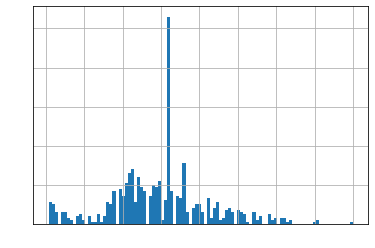

In [26]:
train['Age_Title_Impute'].hist(bins=100)
# train['Age_Title_Pclass_Impute'].hist(bins=100)

In [27]:
for k in range(3,6):
    disc = KBinsDiscretizer(encode='ordinal',n_bins=k)
    col = 'Age_Title_Bin_' + str(k)
    col2 = 'Age_Title_Pclass_Bin_' + str(k)
    train[col] = disc.fit_transform(np.atleast_2d(train['Age_Title_Impute']).T)
    train[col2] = disc.fit_transform(np.atleast_2d(train['Age_Title_Pclass_Impute']).T)
    # print(np.c_[disc.fit_transform(np.atleast_2d(train['Age_Title_Impute']).T),
    #               np.atleast_2d(train['Age_Title_Impute']).T])
# now for my own discretizer:

In [28]:
print('hi')

hi


In [29]:
def myBinDiscretizer1(x):
    if x<16:
        return 0
    elif x<35:
        return 1
    elif x<60:
        return 2
    else:
        return 3
train['Age_Title_Pclass_Bin_Custom'] = train['Age_Title_Pclass_Impute'].apply(lambda x: myBinDiscretizer1(x))
train['Age_Title_Bin_Custom'] = train['Age_Title_Impute'].apply(lambda x: myBinDiscretizer1(x))
train[['Age_Title_Bin_Custom','Age_Title_Pclass_Impute',
       'Age_Title_Pclass_Bin_Custom','Age_Title_Impute']]

,Age_Title_Bin_Custom,Age_Title_Pclass_Impute,Age_Title_Pclass_Bin_Custom,Age_Title_Impute
0,1,22.000000,1,22.000000
1,1,33.000000,1,33.000000
2,0,1.000000,0,1.000000
3,1,16.120370,1,22.151786
4,3,70.000000,3,70.000000
...,...,...,...,...
707,1,21.000000,1,21.000000
708,1,41.021429,2,32.024465
709,2,41.000000,2,41.000000
710,0,14.000000,0,14.000000


check goodness of fit.

In [30]:
train.dtypes

Survived                         int64
Pclass                           int64
Name                            object
Sex                             object
Age                            float64
SibSp                            int64
Parch                            int64
Ticket                          object
Fare                           float64
Cabin                           object
Embarked                        object
Age_is_na                        int32
Cabin_is_na                      int32
Ticket_n                        object
Ticket_pre                      object
Ticket_pre_fill                 object
Cabin_Deck                      object
Relatives                        int64
Has_Relatives                    int32
Title                           object
Cabin_Deck_Ord                   int64
Title_Ord                        int64
Sex_Binary                       int32
Age_Title_Impute               float64
Age_Title_Pclass_Impute        float64
Cabin_Deck_down_to_1     

In [31]:
# survived_scorer = Test_Recorder(train['Survived'],is_numeric=False)
# survived_scorer.add_test(train['Title_Ord'])
# survived_scorer.add_test(train['Age_Title_Bin_Custom'])
# survived_scorer.add_test(train['Age_Title_Pclass_Bin_Custom'])
# survived_scorer.res

In [32]:
hot = OneHotEncoder(sparse=False)
hot_ages = pd.DataFrame(hot.fit_transform(train['Age_Title_Bin_Custom'].to_frame()),columns=hot.get_feature_names(['Age_Title_Bin_Custom']))
print(pd.DataFrame([chi2(hot_ages,train['Survived'])[1],hot_ages.sum(axis=0)]).T)

          0      1
0  0.006228   71.0
1  0.008097  442.0
2  0.010148  183.0
3  0.590019   16.0


Sex \* age \* pclass - m/f \* child/adult \* 1/2/3

In [33]:
hot_sex = pd.DataFrame(hot.fit_transform(train['Sex'].to_frame()),columns=hot.get_feature_names(['Sex']))
hot_class = pd.DataFrame(hot.fit_transform(train['Pclass'].to_frame()),columns=hot.get_feature_names(['Pclass']))

pd.concat([hot_ages,hot_sex,hot_class],axis=1)

,Age_Title_Bin_Custom_0,Age_Title_Bin_Custom_1,Age_Title_Bin_Custom_2,Age_Title_Bin_Custom_3,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
707,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
708,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
709,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
710,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [34]:
df = pd.DataFrame()
# df.append(['a','b'])
for col_sex in hot_sex.columns:
    for col_ages in hot_ages.columns:
        for col_class in hot_class.columns:
            # print(col_sex,col_ages,col_class,'\n',hot_sex[col_sex]*hot_ages[col_ages]*hot_class[col_class])
            # if is child, then don't really care about sex. women and children first.
            # if col_ages[-1]=='0':
            #     name = 'Child'+'_'+col_class
            #     new_series = pd.Series(hot_ages[col_ages]*hot_class[col_class],name=name)
            # else:
            age_sex = col_sex.split('_')[1]
            age_name = 'Age_'+col_ages[-1]
            name = age_sex+'_'+age_name+'_'+col_class
            new_series = pd.Series(hot_sex[col_sex]*hot_ages[col_ages]*hot_class[col_class],name=name)
            # print(new_series)
            df = df.append(new_series)
            # print(df)
            # print('pd',df)
for col_class in hot_class.columns:
    name = 'Child'+'_'+col_class
    new_series = pd.Series(hot_ages.iloc[:,0]*hot_class[col_class],name=name)
    df = df.append(new_series)
df = df.T
df
print(df.columns)
chi2(df,train['Survived'])

Index(['female_Age_0_Pclass_1', 'female_Age_0_Pclass_2',
       'female_Age_0_Pclass_3', 'female_Age_1_Pclass_1',
       'female_Age_1_Pclass_2', 'female_Age_1_Pclass_3',
       'female_Age_2_Pclass_1', 'female_Age_2_Pclass_2',
       'female_Age_2_Pclass_3', 'female_Age_3_Pclass_1',
       'female_Age_3_Pclass_2', 'female_Age_3_Pclass_3', 'male_Age_0_Pclass_1',
       'male_Age_0_Pclass_2', 'male_Age_0_Pclass_3', 'male_Age_1_Pclass_1',
       'male_Age_1_Pclass_2', 'male_Age_1_Pclass_3', 'male_Age_2_Pclass_1',
       'male_Age_2_Pclass_2', 'male_Age_2_Pclass_3', 'male_Age_3_Pclass_1',
       'male_Age_3_Pclass_2', 'male_Age_3_Pclass_3', 'Child_Pclass_1',
       'Child_Pclass_2', 'Child_Pclass_3'],
      dtype='object')


(array([1.06486136e+00, 1.15278810e+01, 1.52438175e+00, 4.26113759e+01,
        3.96248832e+01, 3.08501621e+00, 6.23305234e+01, 2.13216411e+01,
        8.33832304e-02, 3.29368030e+00,            nan, 1.64684015e+00,
        1.64684015e+00, 1.31747212e+01, 1.01025572e+00, 4.74547484e-01,
        1.80118335e+01, 5.23882055e+01, 8.50016270e-01, 1.03378361e+01,
        1.67716302e+01, 9.26812326e-01, 1.21444695e+00, 1.21444695e+00,
        2.35719620e+00, 2.47026022e+01, 1.02480617e-02]),
 array([3.02109035e-01, 6.85601158e-04, 2.16957606e-01, 6.67699335e-11,
        3.07737175e-10, 7.90164778e-02, 2.90389185e-15, 3.88322855e-06,
        7.72763861e-01, 6.95469737e-02,            nan, 1.99389550e-01,
        1.99389550e-01, 2.83750943e-04, 3.14841585e-01, 4.90902519e-01,
        2.19536045e-05, 4.55451131e-13, 3.56547735e-01, 1.30330716e-03,
        4.21589157e-05, 3.35692612e-01, 2.70453199e-01, 2.70453199e-01,
        1.24706147e-01, 6.68937935e-07, 9.19365731e-01]))

In [35]:
y = train['Survived']
print('sex',chi2(hot_sex,y),
      '\nage',chi2(hot_ages,y),
      '\nclass',chi2(hot_class,y))

sex (array([128.39159317,  66.9392067 ]), array([9.21451406e-30, 2.80010277e-16])) 
age (array([7.48314846, 7.01193857, 6.60871819, 0.29031527]), array([0.00622791, 0.0080968 , 0.01014807, 0.59001857])) 
class (array([47.94653257,  4.3794004 , 33.5920899 ]), array([4.38002022e-12, 3.63757916e-02, 6.79685691e-09]))


In [36]:
hot_deck = pd.DataFrame(hot.fit_transform(train['Cabin_Deck_Ord'].to_frame()),columns=hot.get_feature_names(['Deck']))
hot_deck

,Deck_0,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
710,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
train = pd.concat([train,df],axis=1)
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,male_Age_1_Pclass_3,male_Age_2_Pclass_1,male_Age_2_Pclass_2,male_Age_2_Pclass_3,male_Age_3_Pclass_1,male_Age_3_Pclass_2,male_Age_3_Pclass_3,Child_Pclass_1,Child_Pclass_2,Child_Pclass_3
0,1,1,"Cleaver, Miss. Alice",female,22.0,0,0,113781,151.5500,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,"Hunt, Mr. George Henry",male,33.0,0,0,SCO/W 1585,12.2750,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,"Nakid, Miss. Maria (""Mary"")",female,1.0,0,2,2653,15.7417,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.5500,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,1,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
708,0,1,"Cairns, Mr. Alexander",male,NaN,0,0,113798,31.0000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
709,0,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
710,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [38]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Age_is_na', 'Cabin_is_na', 'Ticket_n',
       'Ticket_pre', 'Ticket_pre_fill', 'Cabin_Deck', 'Relatives',
       'Has_Relatives', 'Title', 'Cabin_Deck_Ord', 'Title_Ord', 'Sex_Binary',
       'Age_Title_Impute', 'Age_Title_Pclass_Impute', 'Cabin_Deck_down_to_1',
       'Cabin_Deck_up_to_0', 'Cabin_Deck_down_to_2', 'Cabin_Deck_up_to_1',
       'Cabin_Deck_down_to_3', 'Cabin_Deck_up_to_2', 'Cabin_Deck_down_to_4',
       'Cabin_Deck_up_to_3', 'Cabin_Deck_down_to_5', 'Cabin_Deck_up_to_4',
       'Cabin_Deck_down_to_6', 'Cabin_Deck_up_to_5', 'Cabin_Deck_down_to_7',
       'Cabin_Deck_up_to_6', 'Age_Title_Bin_3', 'Age_Title_Pclass_Bin_3',
       'Age_Title_Bin_4', 'Age_Title_Pclass_Bin_4', 'Age_Title_Bin_5',
       'Age_Title_Pclass_Bin_5', 'Age_Title_Pclass_Bin_Custom',
       'Age_Title_Bin_Custom', 'female_Age_0_Pclass_1',
       'female_Age_0_Pclass_2', 'female_Age_0_Pclass_

In [39]:
deck_class = pd.DataFrame()
for col_deck in hot_deck:
    for col_class in hot_class:
        name = col_deck+'_'+col_class
        new_series = pd.Series(hot_class[col_class]*hot_deck[col_deck],name=name)
        deck_class = deck_class.append(new_series)
deck_class = deck_class.T
deck_class

,Deck_0_Pclass_1,Deck_0_Pclass_2,Deck_0_Pclass_3,Deck_1_Pclass_1,Deck_1_Pclass_2,Deck_1_Pclass_3,Deck_2_Pclass_1,Deck_2_Pclass_2,Deck_2_Pclass_3,Deck_3_Pclass_1,...,Deck_5_Pclass_3,Deck_6_Pclass_1,Deck_6_Pclass_2,Deck_6_Pclass_3,Deck_7_Pclass_1,Deck_7_Pclass_2,Deck_7_Pclass_3,Deck_8_Pclass_1,Deck_8_Pclass_2,Deck_8_Pclass_3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
710,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
train = pd.concat([train,deck_class],axis=1)
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Deck_5_Pclass_3,Deck_6_Pclass_1,Deck_6_Pclass_2,Deck_6_Pclass_3,Deck_7_Pclass_1,Deck_7_Pclass_2,Deck_7_Pclass_3,Deck_8_Pclass_1,Deck_8_Pclass_2,Deck_8_Pclass_3
0,1,1,"Cleaver, Miss. Alice",female,22.0,0,0,113781,151.5500,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,2,"Hunt, Mr. George Henry",male,33.0,0,0,SCO/W 1585,12.2750,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,3,"Nakid, Miss. Maria (""Mary"")",female,1.0,0,2,2653,15.7417,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.5500,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,1,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
708,0,1,"Cairns, Mr. Alexander",male,NaN,0,0,113798,31.0000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
709,0,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
710,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
sacrifice_df = pd.DataFrame()
for col_age in hot_ages.columns[1:]:
    name = 'Male_'+col_age[-1]+'_Has_Relatives'
    new_series = pd.Series(hot_ages[col_age]*hot_sex.iloc[:,1]*train.Has_Relatives,name=name)
    sacrifice_df = sacrifice_df.append(new_series)
sacrifice_df = sacrifice_df.T
train = pd.concat([train,sacrifice_df],axis=1)

In [42]:
train.dtypes[:20]

Survived             int64
Pclass               int64
Name                object
Sex                 object
Age                float64
SibSp                int64
Parch                int64
Ticket              object
Fare               float64
Cabin               object
Embarked            object
Age_is_na            int32
Cabin_is_na          int32
Ticket_n            object
Ticket_pre          object
Ticket_pre_fill     object
Cabin_Deck          object
Relatives            int64
Has_Relatives        int32
Title               object
dtype: object

In [43]:
ticket_col = [t for t in train.columns if 'Ticket' in t]
train[ticket_col].head()

,Ticket,Ticket_n,Ticket_pre,Ticket_pre_fill
0,113781,113781,NaN,-1
1,SCO/W 1585,1585,SCOW,SCOW
2,2653,2653,NaN,-1
3,CA. 2343,2343,CA,CA
4,C.A. 24580,24580,CA,CA


In [44]:
enc = OneHotEncoder(sparse=False,handle_unknown='ignore')
emb = pd.DataFrame(enc.fit_transform(train['Embarked'].fillna('-1').to_frame()),
                   columns=enc.get_feature_names(['Embarked']))
emb
new_train = pd.concat([train,emb],axis=1)
new_train.columns[new_train.isna().sum()>0]

Index(['Age', 'Cabin', 'Embarked', 'Ticket_pre', 'Cabin_Deck'], dtype='object')

In [45]:
plt.figure(figsize=(22,20))
heatmap = train.select_dtypes(exclude=object).drop(['Age'],axis=1)
heatmap.columns[heatmap.isna().sum()>0]
# heatmap = heatmap.corr()
# sns.heatmap(heatmap)

Index([], dtype='object')

<Figure size 1584x1440 with 0 Axes>

In [46]:
kb_df = heatmap.drop(['Fare','Survived'],axis=1)
kb_df.isna().sum(axis=0)
kb = SelectKBest(chi2,k=20)
kb.fit_transform(kb_df,train['Survived'].to_frame())

array([[1., 8., 0., ..., 0., 0., 0.],
       [2., 8., 1., ..., 0., 0., 0.],
       [3., 8., 0., ..., 0., 0., 1.],
       ...,
       [3., 8., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 1., 0.],
       [1., 3., 1., ..., 0., 0., 0.]])

In [47]:
def selectKBest_and_plot(X,y,cols='all',k=6,v=True):
    if cols=='all':
        cols = X.columns
    kb = SelectKBest(chi2,k=k)
    best_cat = pd.DataFrame(kb.fit_transform(X[cols], y),columns=cols[kb.get_support()])
    score_table = pd.DataFrame(np.c_[cols,kb.pvalues_][kb.get_support()],columns=['columns','scores'])
    if v:
        plt.figure(figsize=(8,6))
        plt.bar(cols,kb.scores_)
        plt.title('category scores from Chi2')
        plt.show()
        print(pd.DataFrame(np.c_[cols,kb.scores_],columns=['cat','chi_scores']))
        print('selected: \n',score_table)
    return best_cat,score_table

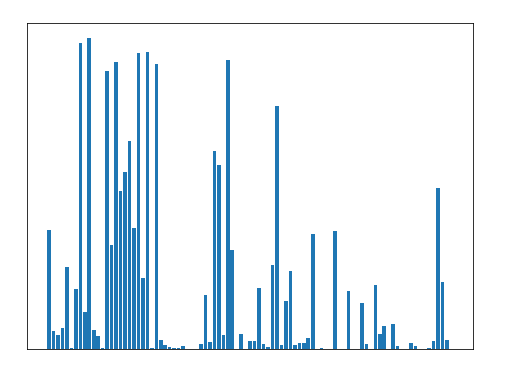

                     cat chi_scores
0                 Pclass    25.6444
1                  SibSp    3.77177
2                  Parch    3.09297
3              Age_is_na    4.54144
4            Cabin_is_na    17.6687
..                   ...        ...
86       Deck_8_Pclass_2    1.72607
87       Deck_8_Pclass_3    34.7338
88  Male_1_Has_Relatives    14.3778
89  Male_2_Has_Relatives    1.82027
90  Male_3_Has_Relatives  0.0252447

[91 rows x 2 columns]
selected: 
                  columns       scores
0                 Pclass  4.10482e-07
1                  SibSp    0.0521243
2                  Parch    0.0786312
3              Age_is_na    0.0330838
4            Cabin_is_na  2.62914e-05
..                   ...          ...
85       Deck_8_Pclass_2     0.188914
86       Deck_8_Pclass_3  3.78011e-09
87  Male_1_Has_Relatives  0.000149553
88  Male_2_Has_Relatives     0.177281
89  Male_3_Has_Relatives     0.873759

[90 rows x 2 columns]


,columns,scores
9,Sex_Binary,2.8001e-16
7,Cabin_Deck_Ord,4.45465e-16
22,Cabin_Deck_down_to_6,1.21217e-15
20,Cabin_Deck_down_to_5,1.43227e-15
40,female_Age_2_Pclass_1,2.90389e-15
15,Cabin_Deck_up_to_1,3.55691e-15
24,Cabin_Deck_down_to_7,4.85862e-15
13,Cabin_Deck_up_to_0,9.55146e-15
50,male_Age_1_Pclass_3,4.55451e-13
18,Cabin_Deck_down_to_4,2.14106e-11


In [48]:

age_cols = [col for col in kb_df if col.startswith('Age')]
res, score_table = selectKBest_and_plot(kb_df,train['Survived'],cols='all',k=90)
# res.iloc[:,[0,1,5,6,8,9]]
score_table.sort_values('scores')[:30]
# lr = RandomForestClassifier(n_estimators=400,max_depth=5)
# lr.fit(cols,y)
# roc_auc_score(y,lr.predict(y.to_frame()))
# X['female_Age_2_Pclass_1'] = X['Sex'] == 0 and X['Pclass'] == 1 and X['Age']>16

In [49]:
def cross_val_score_regular(est,X,y):
    kf = KFold(shuffle=True)
    scores = np.zeros(5)
    for i,(train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        e = est
        e.fit(X_train,y_train)
        scores[i] = roc_auc_score(y_test,e.predict(X_test))
    return scores.mean()

In [50]:
scaler = StandardScaler()
cont_scaled = pd.DataFrame(scaler.fit_transform(train[['Fare','Age_Title_Impute']]),columns=['Fare','Age_Title_Impute'])
final_x = pd.concat([res.iloc[:,[0,1,6,8,9]],cont_scaled],axis=1)
lr = RandomForestClassifier(n_estimators=400,max_depth=5)
score = cross_val_score_regular(RandomForestClassifier(n_estimators=400,max_depth=5),final_x,y)
print(score,'\n',score.mean())


0.7849790009911035 
 0.7849790009911035


In [51]:
from scipy.stats import chi2_contingency
# y[final_x[kb_df.female_Age_1_Pclass_2==1].index].mean()
x = kb_df.Child_Pclass_1
ct = pd.crosstab(x,y)
print(ct)
print('scipy: ',chi2_contingency(ct))
print('\nsklearn: ',chi2(x.to_frame(),y))
# chi2(kb_df.Female_Age_1_Pclass_2.to_frame(),y)

Survived          0    1
Child_Pclass_1          
0.0             442  266
1.0               1    3
scipy:  (1.0456252368430023, 0.3065167899132147, 1, array([[440.51123596, 267.48876404],
       [  2.48876404,   1.51123596]]))

sklearn:  (array([2.3571962]), array([0.12470615]))


In [52]:
train[(train['Age_Title_Impute']<16) & (train.Pclass == 2)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Deck_6_Pclass_3,Deck_7_Pclass_1,Deck_7_Pclass_2,Deck_7_Pclass_3,Deck_8_Pclass_1,Deck_8_Pclass_2,Deck_8_Pclass_3,Male_1_Has_Relatives,Male_2_Has_Relatives,Male_3_Has_Relatives
109,1,2,"Navratil, Master. Michel M",male,3.00,1,1,230080,26.0000,F2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193,1,2,"Mallet, Master. Andre",male,1.00,0,2,S.C./PARIS 2079,37.0042,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
199,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.00,1,2,SC/Paris 2123,41.5792,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
234,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
243,1,2,"Navratil, Master. Edmond Roger",male,2.00,1,1,230080,26.0000,F2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,1,2,"Collyer, Miss. Marjorie ""Lottie""",female,8.00,0,2,C.A. 31921,26.2500,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
259,1,2,"Davies, Master. John Morgan Jr",male,8.00,1,1,C.A. 33112,36.7500,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
280,1,2,"Quick, Miss. Phyllis May",female,2.00,1,1,26360,26.0000,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
347,1,2,"Richards, Master. William Rowe",male,3.00,1,1,29106,18.7500,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
394,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.00,0,1,248727,33.0000,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
